In [1]:
%matplotlib notebook
import numpy as np
import _pickle as cPickle
import os
import gzip
import matplotlib.pyplot as plt

#Fix the seed to get reproducible results for the report. 
#Feel free to comment out this line.
np.random.seed(0)

# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [2]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *brop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

In [3]:
# Simple helpers
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return 1 - np.tanh(x) ** 2

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    d = np.ones_like(x)
    d[x < 0.0] = 0

    return d

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

# Activation function class
class Activation(object):
    
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')
            
    def fprop(self, input):
        # The last input is stored for calculating 
        # the derivative with respect to it later on
        self.last_input = input
        return self.act(input)
    
    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input)

class Layer(object):
    # Base class for layers
    
    def fprop(self, input):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')


# Interface for output layers
# Output layer can be derived from both Layer and Loss 
# Output layers differ from normal ones because they:
#   1 - Have a loss function
#   2 - Dont backpropagate (i.e. being the ouput, they dont receive gradients)
#   3 - Provide the gradient wrt the network output - function input_grad()
class Loss(object):
    # Base class for loss outputs

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

class Parameterized(object):
    # Base class for parameterized things        
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

class InputLayer(Layer):
    # Container for providing input to the network
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input):
        return input
    
    def bprop(self, output_grad):
        return output_grad
        
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer """
    
    def __init__(self, input_layer, num_units, init_stddev, 
                 dropout=0.0, activation_fun=Activation('relu')):
        self.num_units = num_units
        # Keep track of active units. This is important for dropout
        self.active_units = np.ones(num_units)
        self.dropout = dropout
        # Activation function        
        self.activation_fun = activation_fun
        # the input shape will be of size (batch_size, num_units_prev) 
        # where num_units_prev is the number of units in the input (previous) layer
        self.input_shape = input_layer.output_size()
        # this is the weight matrix it should have shape: (num_units_prev, num_units)
        self.W = np.random.normal(scale=init_stddev, size=(self.input_shape[1], self.num_units))
        # and this is the bias vector of shape: (num_units) 
        # This array will be broadcasted to (num_data_points, num_units) later on
        self.b = np.random.rand(self.num_units)
        # Dummy variables for parameter gradients
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        self.dW_r = np.zeros_like(self.W)
        self.dW_s = np.zeros_like(self.W)
        self.db_r = np.zeros_like(self.b)
        self.db_s = np.zeros_like(self.b)
    
    def output_size(self):
        return (self.input_shape[0], self.num_units)
    
    def disable_dropout(self):
        self.active_units = np.ones(self.num_units)
    
    def enable_dropout(self):
        self.active_units = np.random.binomial(1, 1 - self.dropout, self.num_units)
    
    def fprop(self, input):
        """ Forward propagation """

        # last_input is stored for the bprop
        self.last_input = input
        
        # Activation
        a = (input @ self.W + self.b) * self.active_units 

        # Activation function
        if self.activation_fun is None:
            h = a
        else:
            h = self.activation_fun.fprop(a) * self.active_units 

        return h
        
    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """

        # gradient wrt. the activation:
        if self.activation_fun is None:
            act_grad = np.copy(output_grad)
        else:
            act_grad = self.activation_fun.bprop(output_grad)
        
        # gradients wrt. parameters
        n = output_grad.shape[0]
        self.dW = self.last_input.T @ act_grad
        self.db = (np.ones((n, n)) @ act_grad)[0]

        # Dropout
        self.dW *= self.active_units
        self.db *= self.active_units
        active_weights = self.W * self.active_units


        # gradient wrt. the input:
        grad_input = act_grad @ active_weights.T

        # Return gradient wrt. the input, so that it can be used by
        # the next layer to backpropagte (i.e. the previous layer
        # in the network)
        return grad_input
        
    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db


class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
        
    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        n = Y.shape[0]
        return (Y - Y_pred) / n

    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y_pred - Y)
        return np.mean(np.sum(loss, axis=1))

class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input):
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        """ Gradient of the negative log likelihood loss """
        n = Y.shape[0]
        return (Y_pred - Y) / n

    def loss(self, Y, Y_pred):
        # Assume one-hot encoding of Y
        # epsilon is added for numerical stability
        eps = 1e-10
        log_likehood = Y * np.log(Y_pred + eps) 
        loss = -np.sum(log_likehood, axis=1)
        return np.mean(loss)

# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [4]:
class NeuralNetwork:
    """ Our Neural Network container class.
    """
    def __init__(self, layers):
        self.layers = layers
        
    def _loss(self, X, Y):
        Y_pred = self.predict(X)
        return self.layers[-1].loss(Y, Y_pred)

    def predict(self, X):
        """ Calculate an output Y for the given input X. """
        # Forward pass through all layers
        Y_pred = np.copy(X)
        for l in self.layers:
            Y_pred = l.fprop(Y_pred)
        return Y_pred
    
    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        # Start by getting the gradient wrt the network output (prediction)
        next_grad = self.layers[-1].input_grad(Y, Y_pred)

        # and then backpropagate it to previous layers
        for l in np.arange(len(self.layers) - 2, upto - 1, -1):
            next_grad = self.layers[l].bprop(next_grad)

        return next_grad

    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))
        error = Y_pred != Y
        return np.mean(error)
    
    def disable_dropout(self):
        for l in self.layers[1:-1]:
            l.disable_dropout()
    
    def enable_dropout(self):
        for l in self.layers[1:-1]:
            l.enable_dropout()
    
    def reset_adam_moments(self):
        for l in self.layers[1:-1]:
            l.dW_s = np.zeros_like(l.dW)
            l.dW_r = np.zeros_like(l.dW)
            l.db_s = np.zeros_like(l.db)
            l.db_r = np.zeros_like(l.db)
    
    def adam_epoch(self, X, Y, learning_rate, batch_size):
        """ Stochastic gradient descent with adaptive moments (adam) """
        
        # Adam hyperparameters
        rho_1 = .9
        rho_2 = .999
        delta = 1e-8

        # Calculate the number of batches
        n_batches = X.shape[0] // batch_size
        if n_batches < 1:
            n_batches = 1
        
        # Split data into batches
        X_split = np.array_split(X, n_batches)
        Y_split = np.array_split(Y, n_batches)
        
        # For each batch, do a foward and backward pass
        # followed by a layer parameter update
        for b in range(n_batches):
            self.enable_dropout()
            Y_pred = self.predict(X_split[b])
            self.backpropagate(Y_split[b], Y_pred)
            for l in self.layers[1:-1]:
                l.dW_s = rho_1 * l.dW_s + (1 - rho_1) * l.dW
                l.dW_r = rho_2 * l.dW_r + (1 - rho_2) * l.dW ** 2
                l.db_s = rho_1 * l.db_s + (1 - rho_1) * l.db
                l.db_r = rho_2 * l.db_r + (1 - rho_2) * l.db ** 2
                l.W -= learning_rate * l.dW_s / (l.dW_r + delta) ** 0.5
                l.b -= learning_rate * l.db_s / (l.db_r + delta) ** 0.5
        self.disable_dropout()
    
    
    def sgd_epoch(self, X, Y, learning_rate, batch_size):
        """ Stochastic gradient descent """

        # Calculate the number of batches
        n_batches = X.shape[0] // batch_size
        if n_batches < 1:
            n_batches = 1
        
        # Split data into batches
        X_split = np.array_split(X, n_batches)
        Y_split = np.array_split(Y, n_batches)

        # For each batch, do a foward and backward pass
        # followed by a layer parameter update
        for b in range(n_batches):
            self.enable_dropout()
            Y_pred = self.predict(X_split[b])
            self.backpropagate(Y_split[b], Y_pred)
            for l in self.layers[1:-1]:
                l.W -= learning_rate * l.dW
                l.b -= learning_rate * l.db
        self.disable_dropout()
            
    
    def gd_epoch(self, X, Y, learning_rate):
        """ Batch gradient descent """

        Y_pred = self.predict(X)
        self.backpropagate(Y, Y_pred)
        for l in self.layers[1:-1]:
            l.W -= learning_rate * l.dW
            l.b -= learning_rate * l.db


    def train(self, X, Y, X_valid=None, Y_valid=None, learning_rate=0.1, max_epochs=100, batch_size=64,
              descent_type="sgd", y_one_hot=True):
        """ Train network on the given data. """

        if y_one_hot:
            Y_train_hot = one_hot(Y)
        else:
            Y_train_hot = Y

        # Output errors before any training (random network parameters)
        train_loss = [self._loss(X, Y_train_hot)]
        train_error = [self.classification_error(X, Y)]
        if X_valid is not None:
            valid_error = [self.classification_error(X_valid, Y_valid)]
            print('Before training: loss {:.4f}, train error {:.4f}, validation error: {:.4f}'.format(
                train_loss[0], train_error[0], valid_error[0]))
        else:
            print('Before training: loss {:.4f}, train error {:.4f}'.format(
                train_loss[0], train_error[0]))

        print("Starting training. Live plotting will start soon...")
            
        # Plotting stuff
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8))
        ax1.set(ylabel='Loss', xlim=[1, max_epochs+1])
        ax2.set(ylabel='Error', xlabel='Epochs')
        plt.tight_layout()
        plt.ion()
        fig.show()
        fig.canvas.draw()
        
        self.reset_adam_moments()

        # Epoch loop
        for e in range(max_epochs+1):
            if descent_type == "adam":
                self.adam_epoch(X, Y_train_hot, learning_rate, batch_size)
            elif descent_type == "sgd":
                self.sgd_epoch(X, Y_train_hot, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train_hot, learning_rate)

            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            # Loss and errors after the current epoch
            train_loss.append(self._loss(X, Y_train_hot))
            train_error.append(self.classification_error(X, Y))
            if X_valid is not None:
                valid_error.append(self.classification_error(X_valid, Y_valid))
            
            # More plotting stuff
            ax1.clear()
            ax2.clear()
            ax1.set(ylabel='Loss', xlim=[1,max_epochs])
            ax2.set(ylabel='Error', xlabel='Epochs')
            ax1.plot(train_loss[1:])
            ax1.grid()
            ax2.grid(axis='y', which='both')
            ax2.grid(axis='x', which='major')
            ax2.plot(train_error[1:], label='training')
            if X_valid is not None:
                ax2.plot(valid_error[1:], label='validation')
            ax2.legend()
            plt.xticks(np.arange(1, max_epochs+1, 1))
            fig.canvas.draw()
        plt.savefig('epochs.pdf', format='pdf')

        # Final loss and errors
        if X_valid is not None:
            valid_error = [self.classification_error(X_valid, Y_valid)]
            print('After training: loss {:.4f}, train error {:.4f}, validation error: {:.4f}'.format(
                train_loss[-1], train_error[-1], valid_error[-1]))
        else:
            print('After training: loss {:.4f}, train error {:.4f}'.format(
                train_loss[-1], train_error[-1]))
        
    
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape
                    # define functions for conveniently swapping
                    # out parameters of this specific layer and 
                    # computing loss and gradient with these 
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # return the computed gradient 
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))
                    
                    # To debug you network's gradients use scipys
                    # gradient checking!
                    epsilon = 1e-5
                    import scipy.optimize
                    err = scipy.optimize.check_grad(output_given_params, 
                          grad_given_params, param_init) 
                    print('diff scipy {:.2e}'.format(err))
                    assert(err < epsilon)
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)


    def show_classification_sample(self, X, Y, just_mistakes, n_rows = 3, n_cols = 3):
        """
        Function to display some randomly selected digits and its classification
        """
        Y_pred = unhot(self.predict(X))

        if just_mistakes:
            X_sub = X[Y_pred != Y]
            Y_pred_sub = Y_pred[Y_pred != Y]
        else:
            X_sub = X
            Y_pred_sub = Y_pred

        n_show = n_rows * n_cols
        samples = X_sub.shape[0]
        selected = np.random.randint(0, samples, n_show)

        X_sel = X_sub[selected].reshape((n_show, 28, 28))
        Y_pred_sel = Y_pred_sub[selected]
        
        fig, axes = plt.subplots(n_rows, n_cols)
        for it, ax in np.ndenumerate(axes.flatten()):
            ax.matshow(X_sel[it])
            ax.axis('off')
            ax.set_title('Y_pred: ' + str(Y_pred_sel[it]))
        fig.tight_layout()
        plt.savefig('missclas.pdf', format='pdf')
        plt.show()

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [5]:
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [6]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [7]:
nn.check_gradients(X, Y)

checking gradient for layer 1
diff scipy 1.83e-07
diff scipy 7.70e-08
checking gradient for layer 2
diff scipy 1.49e-07
diff scipy 2.17e-08
checking gradient for layer 3
diff scipy 7.95e-08
diff scipy 1.59e-08


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [8]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval

... loading data
... done loading data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [9]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

X_train shape: (50000, 1, 28, 28)
y_train shape: (50000,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [10]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
print("Reshaped X_valid size: {}".format(X_valid.shape))

Reshaped X_train size: (50000, 784)
Reshaped X_valid size: (10000, 784)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

Before training: loss 2.3394, train error 0.9028, validation error: 0.9017
Starting training. Live plotting will start soon...


<IPython.core.display.Javascript object>


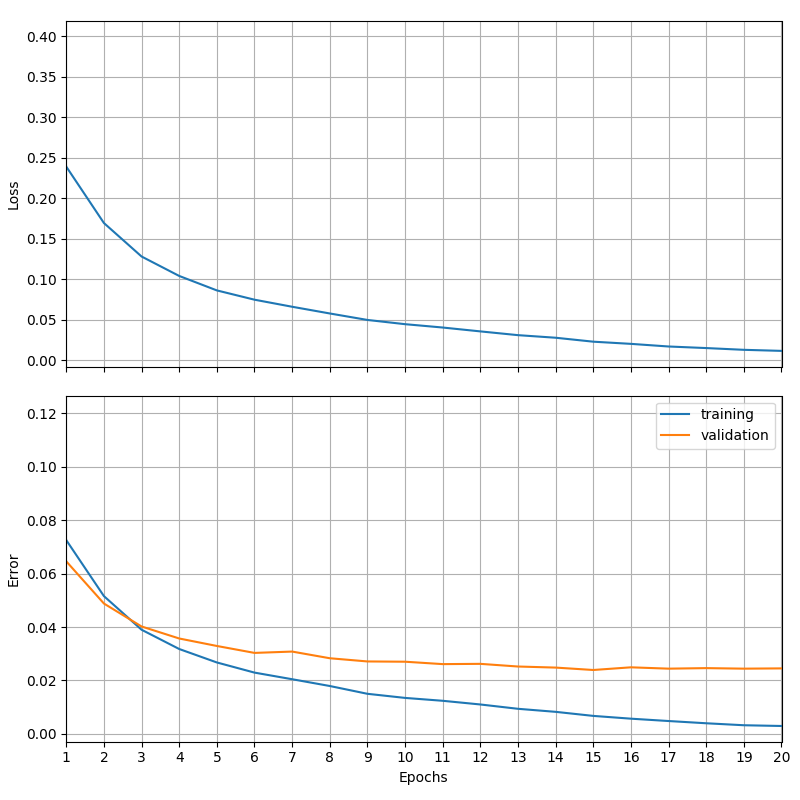

After training: loss 0.0116, train error 0.0029, validation error: 0.0245
Training duration: 81.2s


In [11]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=100,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=100,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.1, 
         max_epochs=20, batch_size=64, y_one_hot=True, descent_type="sgd")
t1 = time.time()
print('Training duration: {:.1f}s'.format(t1-t0))


# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Visualize the validation loss and training loss for each iteration in a plot, e.g. using matplotlib

In [12]:
def MyNetwork():
    """ 
    Returns an UNTRAINED instance of the network whose 
    hyperparameters I optimized
    """
    input_shape = (None, 28*28)
    layers = [InputLayer(input_shape)]
    layers.append(FullyConnectedLayer(
                    layers[-1],
                    num_units=600,
                    init_stddev=0.01,
                    dropout=0.3,
                    activation_fun=Activation('relu')
    ))
    layers.append(FullyConnectedLayer(
                    layers[-1],
                    num_units=500,
                    init_stddev=0.01,
                    dropout=0.2,
                    activation_fun=Activation('relu')
    ))
    layers.append(FullyConnectedLayer(
                    layers[-1],
                    num_units=400,
                    init_stddev=0.01,
                    dropout=0.0,
                    activation_fun=Activation('relu')
    ))
    layers.append(FullyConnectedLayer(
                    layers[-1],
                    num_units=10,
                    init_stddev=0.01,
                    activation_fun=None 
    ))
    layers.append(SoftmaxOutput(layers[-1]))
    return NeuralNetwork(layers)

Before training: loss 2.3557, train error 0.9002, validation error: 0.9039
Starting training. Live plotting will start soon...


<IPython.core.display.Javascript object>


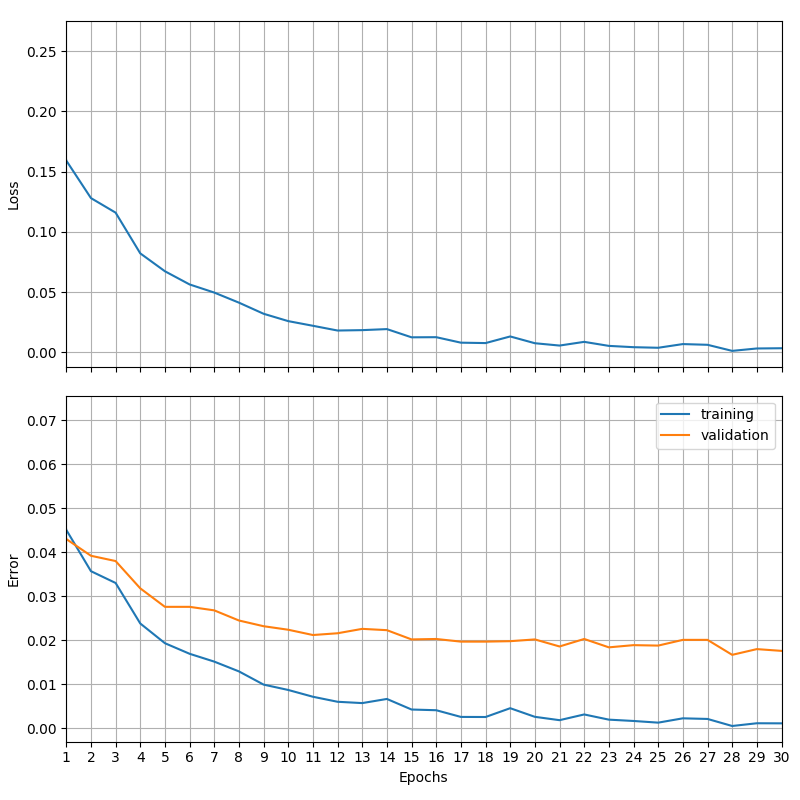

After training: loss 0.0035, train error 0.0011, validation error: 0.0176
Duration: 945.1s


In [13]:
nn = MyNetwork()
t0 = time.time()
nn.train(X_train, y_train, X_valid, y_valid, descent_type="adam",
         learning_rate=0.0002, max_epochs=30, batch_size=64, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

# Final training and test error

Next, the network is trainned on the complete training dataset, i.e. X_train plus X_valid, and tested on the test dataset.


Before training: loss 2.3555, train error 0.8978
Starting training. Live plotting will start soon...


<IPython.core.display.Javascript object>


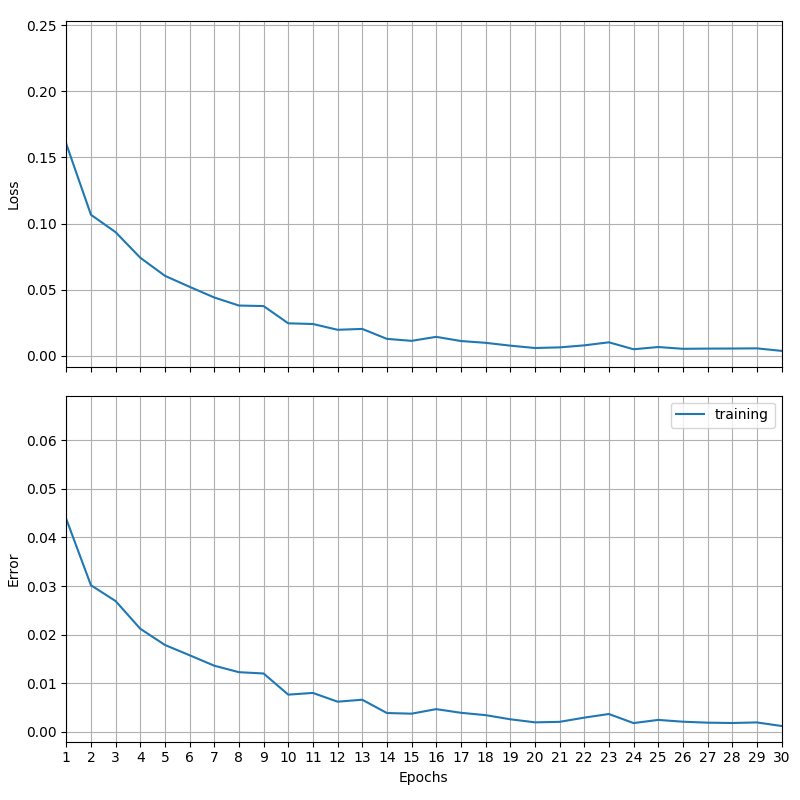

After training: loss 0.0037, train error 0.0012
Duration: 1015.2s
Test error 0.0190


In [14]:
X_train_all = np.vstack((X_train, X_valid))
Y_train_all = np.hstack((y_train, y_valid))

nn = MyNetwork()

# Train neural network
t0 = time.time()
nn.train(X_train_all, Y_train_all, learning_rate=0.0002, max_epochs=30, batch_size=64, 
         y_one_hot=True, descent_type="adam")
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

X_test, y_test = Dtest
X_test = X_test.reshape((X_test.shape[0], -1))
test_error = nn.classification_error(X_test, y_test)

print('Test error {:.4f}'.format(test_error))

# Visualizing the misclassifications

The cell bellow allows us to take a look at the misclassified digits. Each time the cell is run, new random misclassified digits are show.

Is interesting to note that, in general, those digits were written in very "unorthodox" ways.

<IPython.core.display.Javascript object>


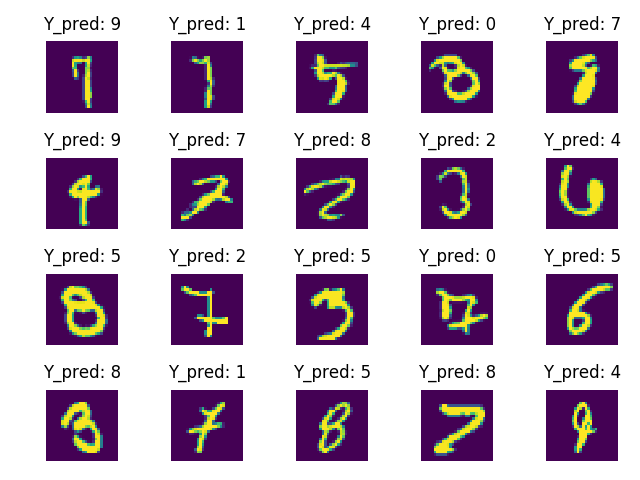

In [22]:
plt.ioff()
nn.show_classification_sample(X_test, y_test, True, 4, 5)